In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import fft 
from Embed import DataEmbedding
from Conv_Blocks import Inception_Block_V1
from sklearn.preprocessing import StandardScaler
from timesfeatures import time_features
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import time 
from timesNet import Model as timesNetModel
from timesNet import TimesBlock, FFT_for_Period
from argparse import Namespace
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

# 1. loading data 
- long term forcast
- data: [ETT-small](https://github.com/zhouhaoyi/ETDataset/tree/main)

In [2]:
data_dir = "/home/scc/Downloads/Datas/ETDataset/ETT-small"
data_file = f'{data_dir}{os.sep}ETTh1.csv'
df = pd.read_csv(data_file).sort_values(by='date', ignore_index=True)
print(df.shape)
print(df['date'].min(), df['date'].max())
df.head()

(17420, 8)
2016-07-01 00:00:00 2018-06-26 19:00:00


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


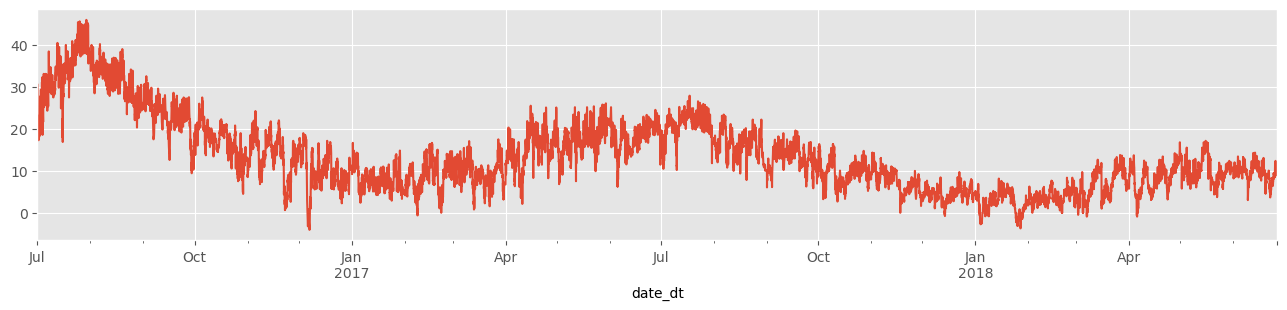

In [3]:
plt.figure(figsize=(16, 3))
df['date_dt'] = pd.to_datetime(df['date'])
df.set_index('date_dt')['OT'].plot()
plt.show()

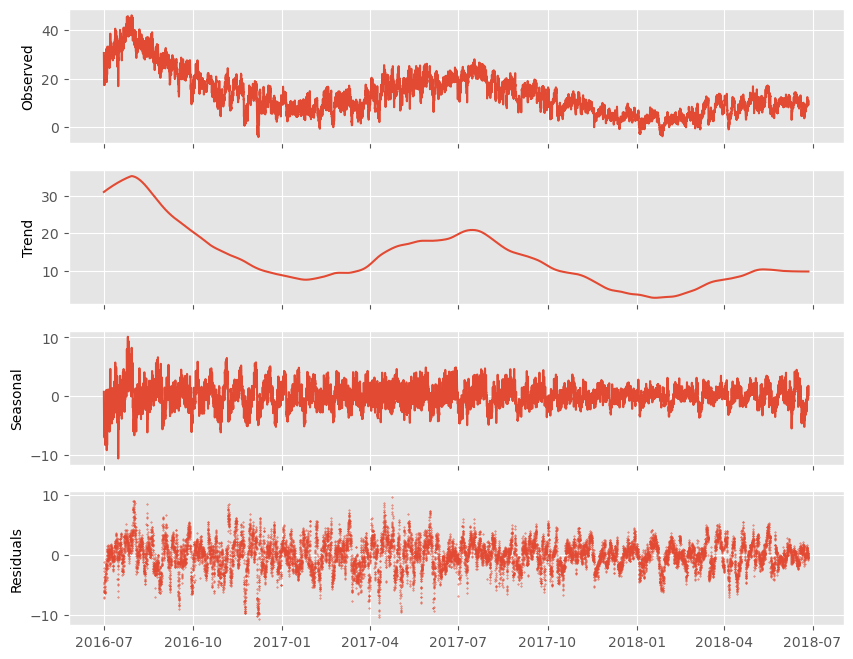

In [84]:

from statsmodels.tsa.seasonal import STL
df_new = df.set_index('date_dt')
decomposition = STL(df_new['OT'], period=30*24).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid, marker='o', linestyle='none', ms=0.35)
ax4.set_ylabel('Residuals')
plt.show()

## 1.1 data Split

- one-month as base
    - train: 12-month 
    - val: 4-month
    - test: 4-month

In [4]:
base_ = 30 * 24 # one-month as base
seq_len = 96
border1s = [0,          12 * base_ - seq_len, (12 + 4) * base_ - seq_len]
border2s = [12 * base_, (12 + 4) * base_,    (12 + 8) * base_]
list(zip(border1s, border2s))

[(0, 8640), (8544, 11520), (11424, 14400)]

## 1.2 dataSet & dataLoader

- dataset: [Time-Series-Library:data_provider/data_loader.py:Dataset_ETT_hour](https://github.com/thuml/Time-Series-Library/blob/main/data_provider/data_loader.py)
- dataLoader: [Time-Series-Library:data_provider/data_factory.py:data_provider](https://github.com/thuml/Time-Series-Library/blob/main/data_provider/data_factory.py)

- about scaler: 
    - TimesNet.forecast & TimesNet.imputation  batch Normalization from Non-stationary Transformer
- return data:
    - series data: seq_x 
    - series data: seq_y (label_len=0 + pred_len)
    - series time: seq_x_mark
        - encode data range: `[-0.5, 0.5]`
        - encode data dim:  4, `[HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]`
    - series time: seq_y_mark (label_len + pred_len)

In [5]:
# [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]
a = time_features(pd.to_datetime(df['date'].values[:2]), freq='h').T
print(a)
df['date'].values[:2]

[[-0.5         0.16666667 -0.5        -0.00136986]
 [-0.45652174  0.16666667 -0.5        -0.00136986]]


array(['2016-07-01 00:00:00', '2016-07-01 01:00:00'], dtype=object)

In [6]:
class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=[24 * 4 * 4, 24 * 4, 24 *4], features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h', seasonal_patterns=None):
        # from figure -> the data didn't have seasonal_patterns
        # size [seq_len, label_len, pred_len]
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        assert flag in ['train', 'val', 'test']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target 
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq 
        
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()
        
    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(f'{self.root_path}{os.sep}{self.data_path}').sort_values(by='date', ignore_index=True)
        base_ = 30 * 24
        border1s = [
            0,
            12 * base_ - self.seq_len, 
            (12 + 4) * base_ - self.seq_len
        ]
        border2s = [
            12 * base_, 
            (12 + 4) * base_, 
            (12 + 8) * base_
        ]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        print(self.set_type, f"{border1} -> {border2}")
        # multi series
        if self.features in ['M', 'MS']: 
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        # single series
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
        
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        if self.timeenc == 1: # encoded as value between [-0.5, 0.5]
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [7]:
seq_len = 96
label_len = 0 
pred_len = 96  
# dec_input = batch_y[:label_len] + [0] * pred_len

tr_data_set = Dataset_ETT_hour(
    root_path=data_dir,
    data_path='ETTh1.csv',
    flag='train',
    size=[seq_len, label_len, pred_len],
    features="S",
    target="OT",
    timeenc=1,
    freq='h',
    seasonal_patterns=None
)
print('train', len(tr_data_set))
tr_data_loader = DataLoader(
    tr_data_set,
    batch_size=32,
    shuffle=True,
    num_workers=10,
    drop_last=True
)

val_data_set = Dataset_ETT_hour(
    root_path=data_dir,
    data_path='ETTh1.csv',
    flag='val',
    size=[seq_len, label_len, pred_len],
    features="S",
    target="OT",
    timeenc=1,
    freq='h',
    seasonal_patterns=None
)
print('val', len(val_data_set))
val_data_loader = DataLoader(
    val_data_set,
    batch_size=32,
    shuffle=True,
    num_workers=10,
    drop_last=True
)


test_data_set = Dataset_ETT_hour(
    root_path=data_dir,
    data_path='ETTh1.csv',
    flag='val',
    size=[seq_len, label_len, pred_len],
    features="S",
    target="OT",
    timeenc=1,
    freq='h',
    seasonal_patterns=None
)
print('test', len(test_data_set))
test_data_loader = DataLoader(
    test_data_set,
    batch_size=1,
    shuffle=False,
    num_workers=10,
    drop_last=True
)


0 0 -> 8640
train 8449
1 8544 -> 11520
val 2785
1 8544 -> 11520
test 2785


In [8]:
seq_x, seq_y, seq_t_x, seq_t_y = tr_data_set[0]
seq_x[:2], seq_y[:2],\
seq_t_x[:2], seq_t_y[:2]

(array([[1.46055158],
        [1.16152666]]),
 array([[0.96221295],
        [0.96221295]]),
 array([[-0.5       ,  0.16666667, -0.5       , -0.00136986],
        [-0.45652174,  0.16666667, -0.5       , -0.00136986]]),
 array([[-0.5       , -0.33333333, -0.36666667,  0.00958904],
        [-0.45652174, -0.33333333, -0.36666667,  0.00958904]]))

# 2- Model Step by Step

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(tr_data_loader):
    x_enc = batch_x.float().to(device)
    x_mark_enc = batch_x_mark.float().to(device)
    batch_y = batch_y.to(device)
    break


## 2.1- batch normalize

In [10]:
means = x_enc.mean(1, keepdim=True).detach()
x_enc = x_enc - means
stdev = torch.sqrt(
    torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5
)
x_enc /= stdev

## 2.2- embedding

embedding = value_embedding(series_data) + temporal_embedding(encode_time) + position_embedding(series_data)

- value_embedding: `nn.Conv1d(in_channels=c_in, out_channels=d_model, kernel_size=3, padding=padding, padding_mode='circular', bias=False)`
- temporal_embedding: `nn.Linear(d_inp, d_model)`
- position_embedding: odd-sin(div_term) even-cos(div_term)
    - `div_term = (torch.arange(0, d_model, 2).float() * -math.log(10000.0) / d_model).exp()`

In [11]:
d_model = 4
enc_embedding = DataEmbedding(1, d_model, 'timeF', 'h', drop=0.1).to(device)
predict_linear = nn.Linear(seq_len, pred_len + seq_len).to(device)
## value_embedding [nn.Conv1d] 
#   + temporal_embedding [nn.Linear(d_inp, d_model)] 
#   + position_embedding [odd-sin(div_term) even-cos(div_term)]
enc_out = enc_embedding(x_enc, x_mark_enc)
print(enc_out.shape)
enc_out = predict_linear(enc_out.permute(0, 2, 1)).permute(0, 2, 1)
print(enc_out.shape)

torch.Size([32, 96, 4])
torch.Size([32, 192, 4])


## 2.3- TimesNet

1. capturing temporal 2D-variations 
    - $A^{l-1},\{f_1,...,f_k\},\{p_1, ..., p_k\}=Period(X^{l-1}_{1D})$
    - $X_{2D}^{l, i}=Reshape_{p_i, f_i}(Padding(X^{l-1}_{1D})), i\in \{1, ..., k\}$  
    - $\hat{X}_{2D}^{l, i}=Inception(X^{l, i}_{2D}), i\in \{1, ..., k\}$   
    - $\hat{X}_{1D}^{l, i}=Trunc(Reshape_{1, p_i\times f_i}(\hat{X}_{2D}^{l, i})),  i\in \{1, ..., k\}$  
        - $X_{2D}^{l, i} \in \mathcal{R}^{p_i \times f_i \times d_{model}}$ 
        - the 2D kernel

2. adaptively aggregating representations
    - $\hat{A}_{f_1}^{l-1}, ..., \hat{A}_{f_k}^{l-1}=Softmax(A_{f_1}^{l-1}, ..., A_{f_k}^{l-1})$
    - $X_{1D}^l = \sum_{i=1}^{k}\hat{A}_{f_i}^{l-1} \times \hat{X}_{1D}^{l, i}$

3. Normalize & projection out


In [12]:
layer_norm = nn.LayerNorm(d_model).to(device)
layer = 2
configs = Namespace(
    seq_len=seq_len,
    pred_len=pred_len,
    top_k=5,
    d_model=d_model,
    d_ff=8,
    num_kernels=6
)
# model = nn.ModuleList([TimesBlock(configs) for _ in range(layer)]).to(device)
# for i in range(layer):
#     enc_out = layer_norm(model[i](enc_out))

In [13]:
# 1 capturing temporal 2D-varations
## Period
B, T, N = enc_out.size()
x = enc_out
period_list, period_weight = FFT_for_Period(x, 5)
period_list, period_weight.shape

res = []
for i in range(5):
    period = period_list[i]
    ## padding
    if (seq_len + pred_len) % period != 0:
        length = ( ((seq_len + pred_len) // period) + 1) * period
        padding = torch.zeros([x.shape[0], (length - ((seq_len + pred_len))), x.shape[2]]).to(x.device)
        out = torch.cat([x, padding], dim=1)
    else:
        length = seq_len + pred_len
        out = x 

    ## Reshape  1D -> 2D 
    ### [B, one-period series-len, period-dim, N-feature dim] ->
    ### [B, N-feature dim, one-period series-len, period-dim]
    out = out.reshape(B, length // period, period, N).permute(0, 3, 1, 2).contiguous()
    print(f"\n[ {i} (period={period}) ] 1D -> 2D: ", out.shape)
    ## Inception 2D conv: from 1d varation to 2d variation
    ## channel first   conv on  pic-(one-period series-len, period-dim)
    # channel[d_model] -> 6-conv, stack, mean -> channel[d_ff]  -> GELU
    # channel[d_ff]    -> 6-conv, stack, mean -> channel[d_model] 
    conv = nn.Sequential(
        Inception_Block_V1(configs.d_model, configs.d_ff, num_kernels=configs.num_kernels),
        nn.GELU(),
        Inception_Block_V1(configs.d_ff, configs.d_model, num_kernels=configs.num_kernels)
    ).to(device)
    out = conv(out)
    print(f"[ {i} (Inception 2D) ] 2D -> \hat_2D: ", out.shape)
    # reshape back -> [B, one-period series-len, period-dim, N-feature dim] -> [B, -1, N]
    out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
    res.append(out[:, :(seq_len + pred_len), :])


[ 0 (period=192) ] 1D -> 2D:  torch.Size([32, 4, 1, 192])
[ 0 (Inception 2D) ] 2D -> \hat_2D:  torch.Size([32, 4, 1, 192])

[ 1 (period=3) ] 1D -> 2D:  torch.Size([32, 4, 64, 3])
[ 1 (Inception 2D) ] 2D -> \hat_2D:  torch.Size([32, 4, 64, 3])

[ 2 (period=2) ] 1D -> 2D:  torch.Size([32, 4, 96, 2])
[ 2 (Inception 2D) ] 2D -> \hat_2D:  torch.Size([32, 4, 96, 2])

[ 3 (period=3) ] 1D -> 2D:  torch.Size([32, 4, 64, 3])
[ 3 (Inception 2D) ] 2D -> \hat_2D:  torch.Size([32, 4, 64, 3])

[ 4 (period=2) ] 1D -> 2D:  torch.Size([32, 4, 96, 2])
[ 4 (Inception 2D) ] 2D -> \hat_2D:  torch.Size([32, 4, 96, 2])


In [14]:
# 2 adaptively aggregating representations
res = torch.stack(res, dim=-1) # 32, 264, 4, 5
print(res.shape)
# adaptive aggregation
period_weight = F.softmax(period_weight, dim=1)
print(period_weight.shape)
# [32, 5] -> [32, 264, 4, 5]
period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
print(period_weight.shape)
# [32, 336, 4, 5] -> [32, 264, 4]
res = torch.sum(res * period_weight, -1)
# residual connection
res = res + x
print(res.shape)

torch.Size([32, 192, 4, 5])
torch.Size([32, 5])
torch.Size([32, 192, 4, 5])
torch.Size([32, 192, 4])


In [15]:
# 3- Normalize & projection out
enc_out = layer_norm(res)
projection = nn.Linear(d_model, 1, bias=True).to(device)
dec_out = projection(enc_out)
print("projection out =", dec_out.shape)
dec_out = dec_out * stdev[:, 0, :].unsqueeze(1).repeat(1, pred_len + seq_len, 1)
dec_out = dec_out + means[:, 0, :].unsqueeze(1).repeat(1, pred_len + seq_len, 1)
print(dec_out.shape)

projection out = torch.Size([32, 192, 1])
torch.Size([32, 192, 1])


In [16]:
criterion = nn.MSELoss()
f_dim = 0
outputs = dec_out[:, -pred_len:, f_dim:]
batch_y = batch_y[:, -pred_len:, f_dim:].to(device)
print(f'outputs.shape={outputs.shape}, batch_y.shape={batch_y.shape}')
loss = criterion(outputs, batch_y)
loss

outputs.shape=torch.Size([32, 96, 1]), batch_y.shape=torch.Size([32, 96, 1])


tensor(0.1883, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

# 3- train

In [17]:
def simple_data_provider(args, flag):
    Data = Dataset_ETT_hour
    timeenc = 0 if args.embed != 'timeF' else 1
    drop_last = True
    shuffle_flag = True
    freq = args.freq
    if flag == 'test':
        shuffle_flag = False
        batch_size = 1
    else:
        batch_size = args.batch_size

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        scale=args.scale,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        seasonal_patterns=args.seasonal_patterns
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)

    return data_set, data_loader

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model_.to(device)
# train_data, train_loader = simple_data_provider(args, flag='train')
    
# for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
#     batch_x = batch_x.float().to(device)
#     batch_y = batch_y.float().to(device)
#     batch_x_mark = batch_x_mark.float().to(device)
#     batch_y_mark = batch_y_mark.float().to(device)
#     outputs = model(batch_x, batch_x_mark, None, None)
#     break

In [19]:
outputs.shape, batch_y.shape

(torch.Size([32, 96, 1]), torch.Size([32, 96, 1]))

In [20]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


def vali(args, model, device, vali_data, vali_loader, criterion):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, None, None)
            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()
            loss = criterion(pred, true)
            total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return total_loss


def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


def train(model, args, setting):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    train_data, train_loader = simple_data_provider(args, flag='train')
    vali_data, vali_loader = simple_data_provider(args, flag='val')
    test_data, test_loader = simple_data_provider(args, flag='test') 

    path = os.path.join(args.checkpoints, setting)
    if not os.path.exists(path):
        os.makedirs(path)

    time_now = time.time()
    train_steps = len(train_loader)
    early_stopping = EarlyStopping(patience=args.patience, verbose=True)
    model_optim = Adam(model.parameters(), lr=args.learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(args.train_epochs):
        iter_count = 0
        train_loss = []

        model.train()
        epoch_time = time.time()
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
            iter_count += 1
            model_optim.zero_grad()
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            # encoder - decoder
            outputs = model(batch_x, batch_x_mark, None, None)
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            loss = criterion(outputs, batch_y)
            train_loss.append(loss.item())

            if (i + 1) % 100 == 0:
                print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
                print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                iter_count = 0
                time_now = time.time()

            loss.backward()
            model_optim.step()

        print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(train_loss)
        vali_loss = vali(args, model, device, vali_data, vali_loader, criterion)
        #test_loss = vali(args, model, device, test_data, test_loader, criterion)
        test_loss = 0.01
        # Test 
        print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Loss: {4:.7f}".format(
            epoch + 1, train_steps, train_loss, vali_loss, test_loss))
        early_stopping(vali_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        adjust_learning_rate(model_optim, epoch + 1, args)

    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))
    torch.cuda.empty_cache()
    return model

In [21]:
args = Namespace(
    task_name='long_term_forecast',
    is_training=1,
    model_id='ETTh1_96_96',
    model='TimesNet',
    data='ETTh1',
    root_path='/home/scc/Downloads/Datas/ETDataset/ETT-small/',
    data_path='ETTh1.csv',
    features='S', # M
    target='OT',
    freq='h',
    scale=True,
    checkpoints='./checkpoints/',
    seq_len=96, # 96 48 96
    label_len=0,
    pred_len=96,
    seasonal_patterns='Monthly',
    top_k=5,
    num_kernels=6,
    enc_in=1, # 7 7 7
    dec_in=1,
    c_out=1,
    d_model=6, # 16
    e_layers=3, # 2
    d_ff=12,
    dropout=0.1,
    embed='timeF',
    # embed='fixed',
    output_attention=False,
    num_workers=10,
    itr=1,
    train_epochs=10,
    batch_size=32,
    patience=100,
    learning_rate=1.5e-4, #1e-4,
    loss='MSE',
    lradj='type1',
    use_amp=False
)
setting = f'{args.task_name}_timesNet'
# model-shell
# args = Namespace(task_name='long_term_forecast', is_training=1, model_id='ETTh1_96_96', model='TimesNet', data='ETTh1', root_path='/home/scc/Downloads/Datas/ETDataset/ETT-small/', data_path='ETTh1.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, seasonal_patterns='Monthly', inverse=False, mask_rate=0.25, anomaly_ratio=0.25, top_k=5, num_kernels=6, enc_in=7, dec_in=7, c_out=7, d_model=16, n_heads=8, e_layers=2, d_layers=1, d_ff=32, moving_avg=25, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='MSE', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[128, 128], p_hidden_layers=2)
# model_ = timesNetModel(args)

In [22]:
model_ = timesNetModel(args)
model_ = train(model_, args, setting)

0 0 -> 8640
train 8449
1 8544 -> 11520
val 2785
2 11424 -> 14400
test 2785


	iters: 100, epoch: 1 | loss: 0.1944048
	speed: 0.0297s/iter; left time: 75.5006s
	iters: 200, epoch: 1 | loss: 0.1778224
	speed: 0.0314s/iter; left time: 76.6446s
Epoch: 1 cost time: 8.182040929794312
Epoch: 1, Steps: 264 | Train Loss: 0.1914031 Vali Loss: 0.1078961 Loss: 0.0100000
Validation loss decreased (inf --> 0.107896).  Saving model ...
Updating learning rate to 0.00015
	iters: 100, epoch: 2 | loss: 0.1445102
	speed: 0.0686s/iter; left time: 156.2256s
	iters: 200, epoch: 2 | loss: 0.1114639
	speed: 0.0316s/iter; left time: 68.7490s
Epoch: 2 cost time: 8.479076623916626
Epoch: 2, Steps: 264 | Train Loss: 0.1760426 Vali Loss: 0.1059443 Loss: 0.0100000
Validation loss decreased (0.107896 --> 0.105944).  Saving model ...
Updating learning rate to 7.5e-05
	iters: 100, epoch: 3 | loss: 0.1182536
	speed: 0.0691s/iter; left time: 139.1579s
	iters: 200, epoch: 3 | loss: 0.1538416
	speed: 0.0314s/iter; left time: 60.0663s
Epoch: 3 cost time: 8.559822797775269
Epoch: 3, Steps: 264 | Trai

In [23]:
# load
model_f = '/home/scc/Downloads/Time-Series-Library/checkpoints/long_term_forecast_ETTh1_96_96_TimesNet_ETTh1_ftM_sl96_ll48_pl96_dm16_nh8_el2_dl1_df32_fc3_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
model_ = timesNetModel(args)
model_.load_state_dict(
    torch.load(model_f, map_location='cpu')
)
model_ = model_.to(device)

In [88]:
args.scale = True
val_data_set = Dataset_ETT_hour(
    root_path=data_dir,
    data_path='ETTh1.csv',
    flag='val',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    scale=args.scale,
    target="OT",
    timeenc=1,
    freq='h',
    seasonal_patterns=None
)
print('val', len(val_data_set))
val_data_loader = DataLoader(
    val_data_set,
    batch_size=32,
    shuffle=True,
    num_workers=10,
    drop_last=True
)


test_data_set = Dataset_ETT_hour(
    root_path=data_dir,
    data_path='ETTh1.csv',
    flag='val',
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    scale=args.scale,
    target="OT",
    timeenc=1,
    freq='h',
    seasonal_patterns=None
)
print('test', len(test_data_set))
test_data_loader = DataLoader(
    test_data_set,
    batch_size=1,
    shuffle=False,
    num_workers=10,
    drop_last=True
)

i_set = 180
model_.eval()
with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float()

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        # encoder - decoder
        outputs = model_(batch_x, batch_x_mark, None, None)
        pred = outputs.detach().cpu()
        true = batch_y[:, -args.pred_len:, :].detach().cpu()
        if i == i_set:
            break

1 8544 -> 11520
val 2785
1 8544 -> 11520
test 2785


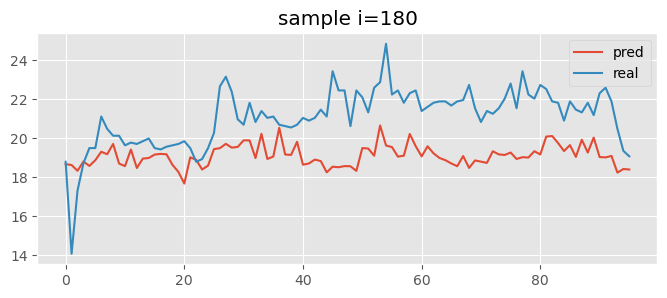

In [89]:
for b in range(pred.shape[0]):
    plt.figure(figsize=(8, 3))
    try:
        plt.plot(test_data_set.inverse_transform(pred[b].numpy())[:, -1].flatten(), label='pred')
        plt.plot(test_data_set.inverse_transform(true[b].numpy())[-args.pred_len:, -1].flatten(), label='real')
    except Exception as e:
            plt.plot(pred[b].numpy()[:, -1].flatten(), label='pred')
            plt.plot(true[b].numpy()[:, -1].flatten(), label='real')
    plt.legend()
    plt.title(f'sample i={i_set}')
    plt.show()
    break

In [75]:
# it didnt work well in some period not signficient data